In [17]:
from typing import Union
import datasets as dt
import models.SpinalNet as snet # needs images.to("cuda")
import models.CapsuleNetwork as cnet
from torch.utils.data import DataLoader
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
from collections import Counter
from os.path import relpath
from json import dump
from pathlib import Path

device = "cuda"

dataset_name = "dida_clean"
transform = "binary"
model = "capsnet"
experiment_name = f"{model}_{dataset_name}_{transform}"

# Same-sized input
dataset = dt.get_historical_dataset(transform)
raw_loader = DataLoader(dataset, 128, num_workers=4, shuffle=True)
idx_to_class = {idx: cls for cls, idx in dataset.class_to_idx.items()}

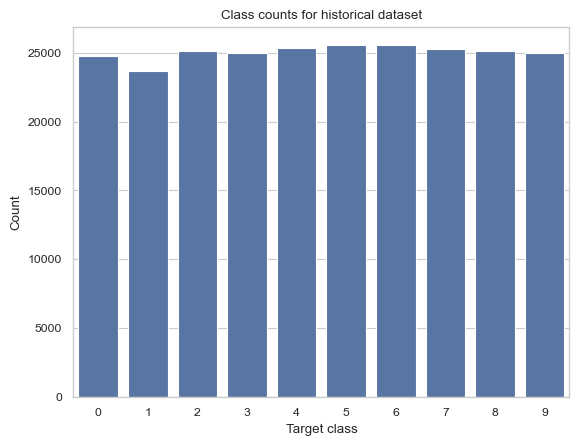

In [5]:
import seaborn as sns
sns.set_theme("paper", "whitegrid")

classes = dict(Counter(dataset.targets))
classes = {idx_to_class[idx]: count for idx, count in classes.items()}

plot = sns.barplot(classes)
plot.set_title("Class counts for historical dataset")
plot.set_xlabel("Target class")
plot.set_ylabel("Count")
plt.savefig(f"./imgs/{dataset_name}_count.pdf")

In [18]:
model = snet.get_model() if model == "spinalnet" else cnet.get_model()
model = model.to(device)
model.eval()

n_correct_chars = np.zeros(len(dt.EMNIST_TRAIN.classes))
count_chars = np.zeros(len(dt.EMNIST_TRAIN.classes))

remapping = {
    36: 10,
    37: 11,
    38: 13,
    39: 14,
    40: 15,
    41: 16,
    42: 17,
    43: 23,
    44: 26,
    45: 27,
    46: 29,
}
mapper = lambda x: remapping.get(x, x)
decoder = {v: k for k, v in dt.EMNIST_TRAIN.class_to_idx.items()}

with open(f"./{experiment_name}_results.csv", "w") as f:
    f.write("image,predicted,true\n")

pbar = tqdm(raw_loader)
for images, labels, file_names in pbar:
    with torch.no_grad():
        preds: Union[tuple[Tensor, Tensor, Tensor], Tensor] = model(images.to(device))
        if isinstance(preds, tuple):
            preds = preds[2].to("cpu")
        else:
            preds = torch.max(preds.data, 1)[1].to("cpu")

        preds = Tensor([mapper(pred.item()) for pred in preds]).int()
        correct_labels = preds == labels

        with open(f"./{experiment_name}_results.csv", "a") as f:
            for path, pred, label in zip(file_names, preds, labels):
                f.write(
                    f"{Path(relpath(path, '.')).as_posix()},{decoder[pred.item()]},{idx_to_class[label.item()]}\n"
                )

        np.add.at(n_correct_chars, labels[correct_labels], 1)
        np.add.at(count_chars, labels, 1)
        pbar.set_description(
            f"Partial accuracy: {np.sum(n_correct_chars) / np.sum(count_chars):.5f}"
        )

char_accuracy = n_correct_chars / count_chars

  0%|          | 0/1958 [00:00<?, ?it/s]

C:\Users\stefa\AppData\Local\Temp\ipykernel_4248\3853577546.py:51: RuntimeWarning: invalid value encountered in divide
  char_accuracy = n_correct_chars / count_chars


In [19]:
character_accuracy = {}

for idx, acc in enumerate(char_accuracy):
    if not np.isnan(acc):
        character_accuracy[idx_to_class[idx]] = acc

with open(f"./json/{experiment_name}_class_accuracy.json", "w") as f:
    dump(character_accuracy, f, indent=4)